# Imports

Importing all the libraries that are going to be used

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from tqdm import notebook
import re
import itertools
import time
from faker import Factory
import string
import random
sns.set_style('white')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, GaussianNoise
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading the data

In [2]:
# collected from: https://www.osinsci.xyz/powerbi/uk-postcode-regions-for-analytics/
postcodes = pd.read_excel('./data/postcodes_regions.xlsx')

In [3]:
df = pd.read_csv('./data/data_anonymised.csv')

In [4]:
df.head()

,transaction_time,event_id,account_number,merchant_id,merchant_category,merchant_country,merchant_zip,pos_entry_mode,transaction_amount,available_cash,reported_time,fraud
0,2017-01-01T00:00:00Z,3uudfau,689e9eex9,a7214a1,09dac984,826,CR0,1,10.29,7249,NaN,0
1,2017-01-01T00:49:03Z,4534h14,35a333qg,3hh91886e,4p89335c,826,DE14,81,21.02,4689,NaN,0
2,2017-01-01T00:43:17Z,s0b2ccs,8h8eefff,222c6f94r,adzz727i,442,NaN,81,5.48,10408,NaN,0
3,2017-01-01T00:15:07Z,fap81bbcg,7710hha8p,5a51a11,4p89335c,826,NR1,81,19.43,7249,NaN,0
4,2017-01-01T00:37:09Z,c22dd72,9ff58c3qu,5e9c1cd,023u221,826,M50,81,42.54,10807,NaN,0


Severely imbalanced dataset

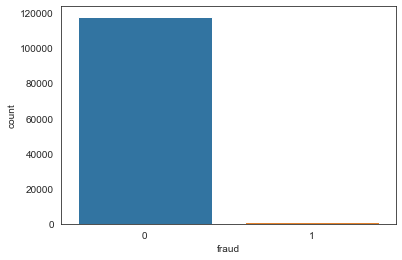

In [5]:
sns.countplot(x='fraud', data=df)

In [6]:
def print_unique_values(df):
    """
    Print the unique values for each column
    """
    print(f'df length: {len(df)}')
    print(f'{"Column name":25} | {"Unique"}')
    print('-'*40)
    for col in df.columns:
        print(f'{col:25} | {len(df[col].unique())} ')
print_unique_values(df)

df length: 118621
Column name               | Unique
----------------------------------------
transaction_time          | 118105 
event_id                  | 118621 
account_number            | 766 
merchant_id               | 33327 
merchant_category         | 361 
merchant_country          | 82 
merchant_zip              | 3261 
pos_entry_mode            | 10 
transaction_amount        | 19295 
available_cash            | 19 
reported_time             | 146 
fraud                     | 2 


# Exploratory data analysis and feature engineering

## Missing values

How much time does it take for a transaction to be reported as fraud?

In [7]:
df['reported_time'] = pd.to_datetime(df['reported_time'])

In [8]:
reported_vs_transaction = df[df['reported_time'].notna()].reset_index(drop=True)

In [9]:
reported_vs_transaction.loc[:, 'reported-transaction'] = reported_vs_transaction['reported_time'] - pd.to_datetime(reported_vs_transaction['transaction_time'])

In [10]:
reported_vs_transaction['reported-transaction'].apply(lambda x: x.total_seconds()/60/60).mean()

227.37553746031745

In [11]:
reported_vs_transaction['reported-transaction'].apply(lambda x: x.total_seconds()/60/60).median()

84.10166666666667

In [12]:
reported_vs_transaction['reported-transaction'].apply(lambda x: x.total_seconds()/60/60).std()

399.26917182154597

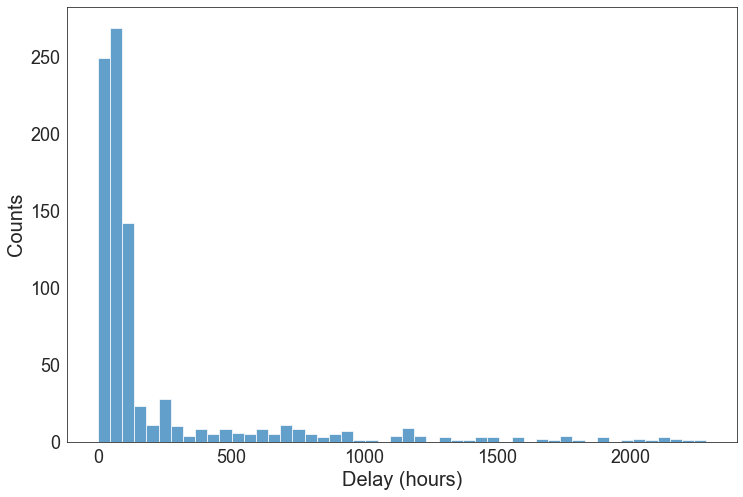

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
reported_vs_transaction['reported-transaction'].apply(lambda x: x.total_seconds()/60/60).plot(kind='hist',
                                                                                              bins=50,
                                                                                              ax=ax,
                                                                                             alpha=0.7)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('Counts', fontsize=20)
ax.set_xlabel('Delay (hours)', fontsize=20)
# ax.set_title('Delay before reporting a transation as fraud (hours)')
plt.savefig('delay_for_the_report.png', dpi=600, bbox_inches='tight')
plt.show()

Missing values

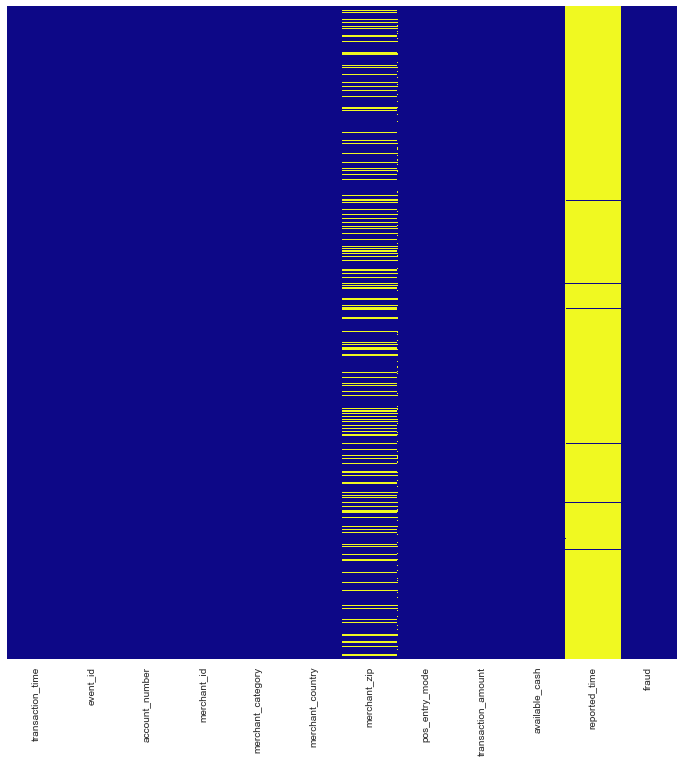

In [14]:
plt.subplots(figsize=(12, 12))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False, cmap='plasma')
plt.show()

### Unique countries in the missing merchant zips

In [15]:
foo = df[df['merchant_zip'].isna()]['merchant_country'].unique()
foo.sort()
foo

array([ 31,  32,  36,  40,  48,  50,  52,  56,  60,  76, 100, 116, 124,
       144, 152, 156, 158, 191, 196, 203, 208, 214, 233, 246, 250, 268,
       276, 292, 300, 312, 336, 344, 348, 352, 356, 372, 376, 380, 388,
       392, 404, 410, 438, 442, 446, 458, 462, 470, 480, 484, 492, 504,
       528, 531, 534, 554, 566, 578, 591, 608, 616, 620, 634, 642, 643,
       659, 662, 702, 703, 704, 710, 724, 752, 756, 764, 784, 788, 792,
       804, 818, 840], dtype=int64)

In [16]:
df['merchant_country'].value_counts().head(20)

826    95616
442    14929
840     2873
372     1414
250      483
528      406
724      298
380      247
276      240
292      216
196      186
124      142
208      136
756      132
752       94
710       94
344       89
36        83
620       59
470       51
Name: merchant_country, dtype: int64

In [17]:
df[df['merchant_zip'].isna()]['merchant_country'].value_counts().head(50)

442    14929
840     2873
372     1414
250      483
528      406
724      298
380      247
276      240
292      216
196      186
124      142
208      136
756      132
710       94
752       94
344       89
36        83
620       59
470       51
480       48
246       39
591       38
56        38
392       37
300       36
156       35
792       34
484       33
764       30
578       30
554       29
40        29
608       29
352       28
31        28
76        23
784       21
534       20
616       18
818       15
376       15
356       14
388       14
52        14
203       13
702       11
348       11
643        9
659        8
144        8
Name: merchant_country, dtype: int64

Only country 826 - UK presumably, has Zip Code

## Top overview

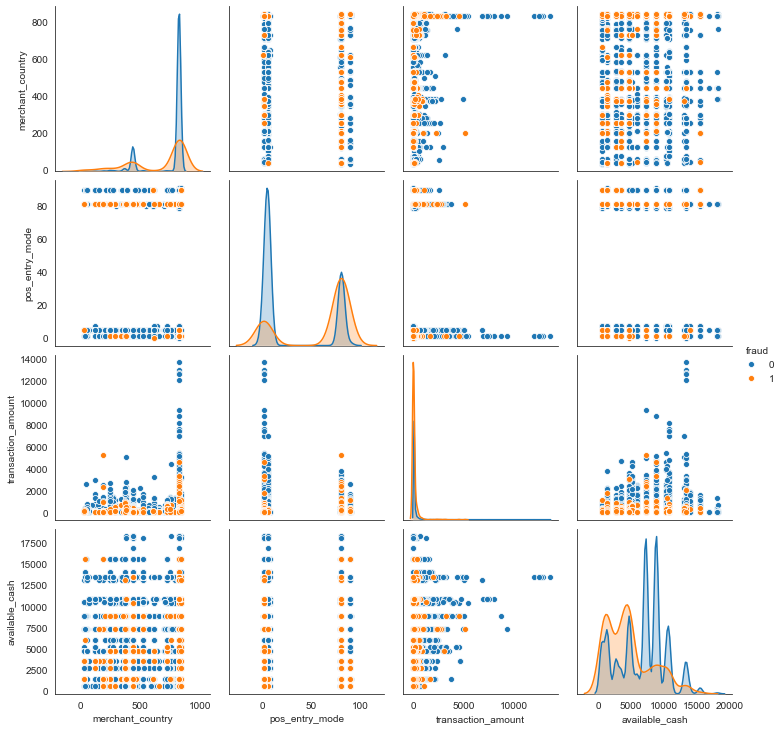

In [18]:
sns.pairplot(df, hue='fraud')

## Transaction amounts and available cash distributions

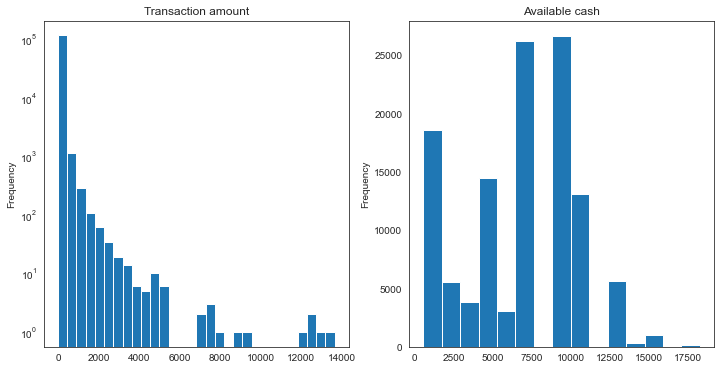

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Transaction amount')
df['transaction_amount'].plot(kind='hist', logy=True, ax=axes[0], bins=30)
axes[1].set_title('Available cash')
df['available_cash'].plot(kind='hist', logy=False, ax=axes[1], bins=15)
plt.show()

## Count by POS Entry mode for Fraud and not

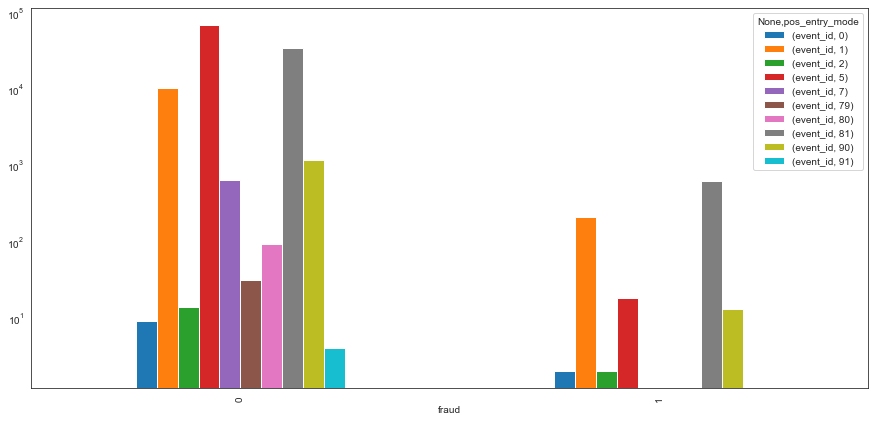

In [20]:
df.groupby(['fraud', 'pos_entry_mode']).count()[['event_id']].unstack().plot(kind='bar', logy=True, figsize=(15, 7))

In [21]:
df_gb_by_pos_entry_mode = df.groupby(['fraud', 'pos_entry_mode']).count()[['event_id']].reset_index()
df_gb_by_pos_entry_mode.loc[df_gb_by_pos_entry_mode['fraud'] == 0, 'pct'] = \
    df_gb_by_pos_entry_mode[df_gb_by_pos_entry_mode['fraud']== 0]['event_id'] / len(df[df['fraud'] == 0])
df_gb_by_pos_entry_mode.loc[df_gb_by_pos_entry_mode['fraud'] == 1, 'pct'] = \
    df_gb_by_pos_entry_mode[df_gb_by_pos_entry_mode['fraud']== 1]['event_id'] / len(df[df['fraud'] == 1])

### POS Entry mode pct

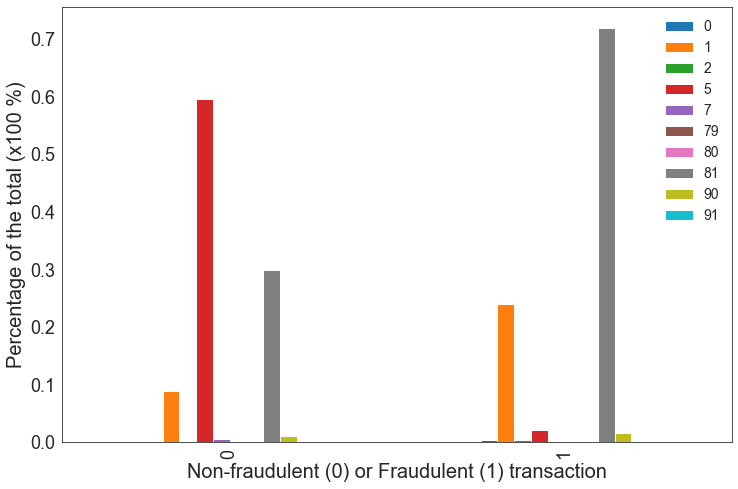

In [22]:


fig, ax = plt.subplots(figsize=(12,8))
df_gb_by_pos_entry_mode.fillna('Entry Mode Unkown').set_index(['fraud', 'pos_entry_mode'])['pct'].unstack().plot(kind='bar',
                                                                           ax=ax)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('Percentage of the total (x100 %)', fontsize=20)
ax.set_xlabel('Non-fraudulent (0) or Fraudulent (1) transaction', fontsize=20)
# ax.set_title('Delay before reporting a transation as fraud (hours)')
plt.legend(fontsize=14, frameon=False)
plt.savefig('fraudulent vs non fraud pct POS mode.png', dpi=600, bbox_inches='tight')
plt.show()

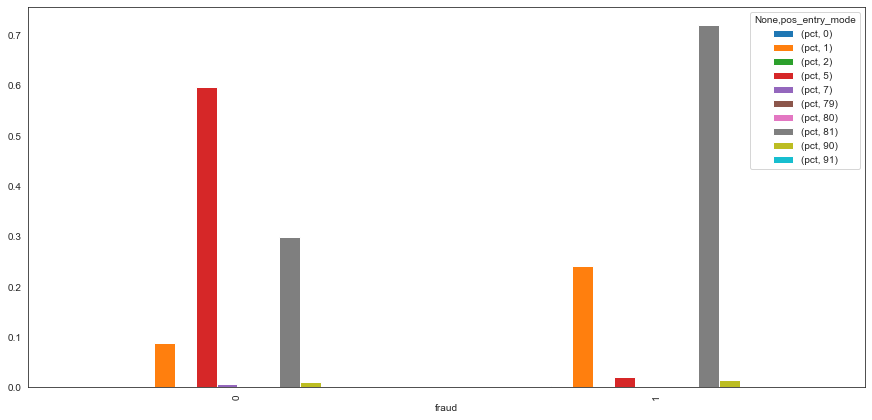

In [23]:
df_gb_by_pos_entry_mode.set_index(['fraud', 'pos_entry_mode'])[['pct']].unstack().plot(kind='bar', 
                                                                                        figsize=(15, 7))

## Part of day bins

Convert to `datetimes` to check if there is anything special with the time of day

In [24]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

In [25]:
df['transaction_time_time'] = df['transaction_time'].dt.time
df['transaction_time_month'] = df['transaction_time'].dt.month
df['transaction_time_year'] = df['transaction_time'].dt.year

We can use different times for the bins or more/less depending on how the model reacts

In [26]:
df['bins'] = pd.cut(df['transaction_time'].dt.hour, 
      bins=[2,
            8,
            14,
            20,],
      labels=['02-08',
              '08-14',
              '14-20'],
      include_lowest=True).values.add_categories('20-02').fillna('20-02')

In [27]:
df_gb_by_bins = df.groupby(['fraud', 'bins']).count()[['event_id']].reset_index()
df_gb_by_bins.loc[df_gb_by_bins['fraud'] == 0, 'pct'] = \
    df_gb_by_bins[df_gb_by_bins['fraud']== 0]['event_id'] / len(df[df['fraud'] == 0])
df_gb_by_bins.loc[df_gb_by_bins['fraud'] == 1, 'pct'] = \
    df_gb_by_bins[df_gb_by_bins['fraud']== 1]['event_id'] / len(df[df['fraud'] == 1])

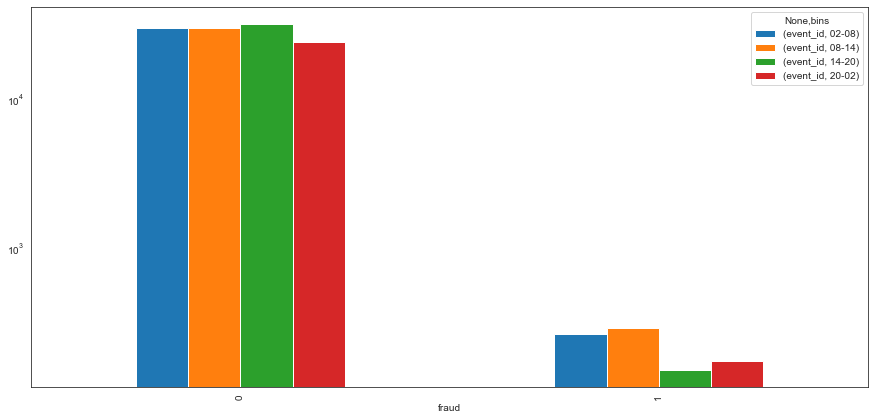

In [28]:
df.groupby(['fraud', 'bins']).count()[['event_id']].unstack().plot(kind='bar', logy=True, figsize=(15, 7))

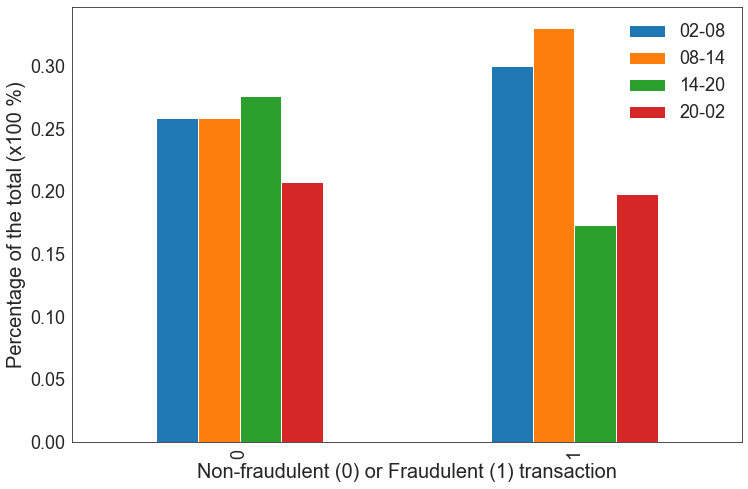

In [29]:
fig, ax = plt.subplots(figsize=(12,8))


df_gb_by_bins.set_index(['fraud', 'bins'])['pct'].unstack().plot(kind='bar',
                                                                   ax=ax)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('Percentage of the total (x100 %)', fontsize=20)
ax.set_xlabel('Non-fraudulent (0) or Fraudulent (1) transaction', fontsize=20)
# ax.set_title('Delay before reporting a transation as fraud (hours)')
plt.legend(fontsize=18, frameon=False)
plt.savefig('fraudulent vs non fraud pct.png', dpi=600, bbox_inches='tight')
plt.show()

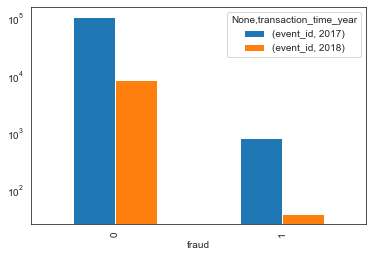

In [30]:
df.groupby(['fraud', 'transaction_time_year']).count()[['event_id']].unstack().plot(kind='bar', logy=True)

Month and Year of the transaction don't seem to add any value, not complete

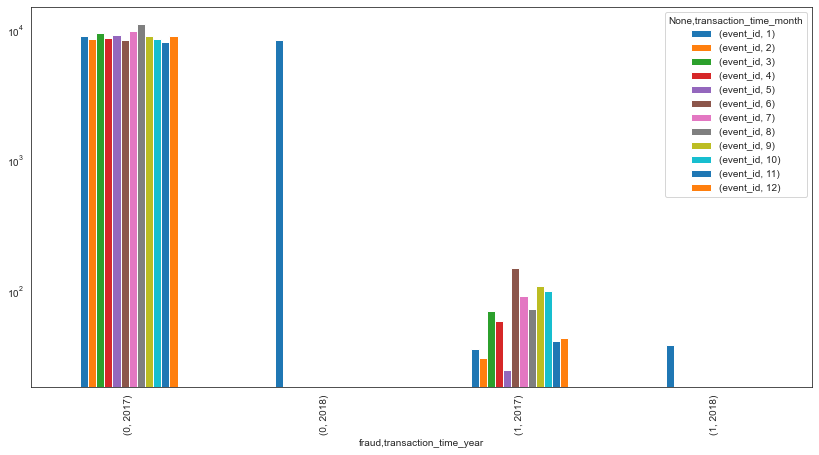

In [31]:
df.groupby(['fraud',
            'transaction_time_year',
            'transaction_time_month']).count()[['event_id']].unstack().plot(kind='bar',
                                                                          figsize=(14, 7),
                                                                          logy=True)

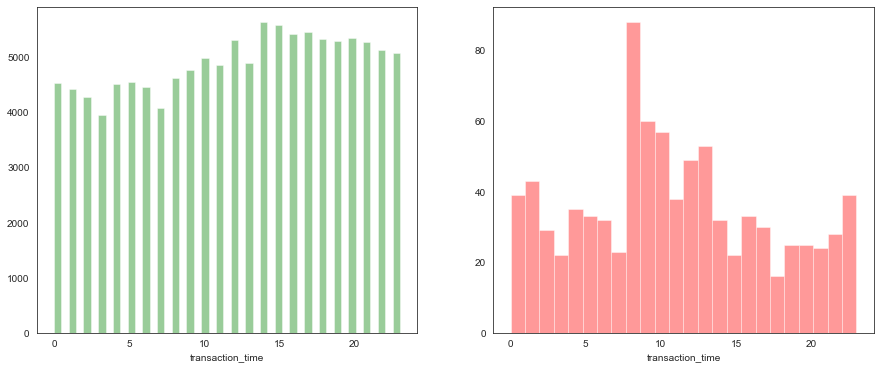

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(df[df['fraud'] == 0]['transaction_time'].dt.hour, kde=False, ax=axes[0], color='green')
sns.distplot(df[df['fraud'] == 1]['transaction_time'].dt.hour, kde=False, ax=axes[1], color='red', bins=24)

## UK Regions

Create a column on the back of the `merchant_zip` column as the UK regions, since country 826, the UK, has the most entries

Further to the UK, create a specific column for country 442, 840 and 372, while all the rest will be under a generic 'other' country.

These columns will be later used to create one-hot encoded dummies

There are only 1 and 2 letter postcodes prefices 

In [33]:
postcodes['Prefix'].apply(len).value_counts()

2    115
1      8
Name: Prefix, dtype: int64

Match 1 or 2 characters a-z or A-Z followed by 1 or 2 digits, in each merchant zip code

In [34]:
df['match'] = df[df['merchant_zip'].notna()]['merchant_zip'].apply(lambda x: re.match(pattern=r'[a-zA-Z]{1,2}', string=x))

In [35]:
df['post_code_start'] = df[df['match'].notna()]['match'].apply(lambda x: x[0])

In [36]:
df['uk_region'] = df[df['post_code_start'].notna()]['post_code_start'].str.upper().map(postcodes.set_index('Prefix')['Region'].to_dict())

In [37]:
df.loc[(df['match'].isna()) & (df['merchant_country'] == 826), 'uk_region'] = 'other'

In [38]:
df.loc[(df['uk_region'].isna()) & (df['merchant_country'] == 826), 'uk_region'] = 'other'

In [39]:
print(df['uk_region'].value_counts().sum())
df['uk_region'].value_counts()

95616


London                      17843
other                       15491
South East England          15069
East of England              8480
South West England           6843
Scotland                     5904
North West England           5729
Yorkshire and the Humber     5503
West Midlands                5365
East Midlands                4238
North East England           2363
Wales                        1474
Northern Ireland             1072
Channel Islands               242
Name: uk_region, dtype: int64

In [40]:
df['country_for_dummies'] = df[df['uk_region'].notna()].apply(lambda x: str(x['merchant_country']) + '_' + x['uk_region'].replace(' ', ''), axis=1)

In [41]:
df.loc[df['merchant_country'] == 442, 'country_for_dummies'] = 'country_442'

In [42]:
df.loc[df['merchant_country'] == 840, 'country_for_dummies'] = 'country_840'

In [43]:
df.loc[df['merchant_country'] == 372, 'country_for_dummies'] = 'country_372'

In [44]:
df.loc[df['country_for_dummies'].isna(), 'country_for_dummies'] = 'country_other'

In [45]:
df['country_for_dummies'].value_counts()

826_London                   17843
826_other                    15491
826_SouthEastEngland         15069
country_442                  14929
826_EastofEngland             8480
826_SouthWestEngland          6843
826_Scotland                  5904
826_NorthWestEngland          5729
826_YorkshireandtheHumber     5503
826_WestMidlands              5365
826_EastMidlands              4238
country_other                 3789
country_840                   2873
826_NorthEastEngland          2363
826_Wales                     1474
country_372                   1414
826_NorthernIreland           1072
826_ChannelIslands             242
Name: country_for_dummies, dtype: int64

In [46]:
df_gb_countries = df[df['fraud'] == 1].groupby(['fraud', 'country_for_dummies']).count()[['event_id']]
df_gb_countries['pct'] = df_gb_countries['event_id'] / df_gb_countries['event_id'].sum()
df_gb_countries.reset_index(inplace=True)

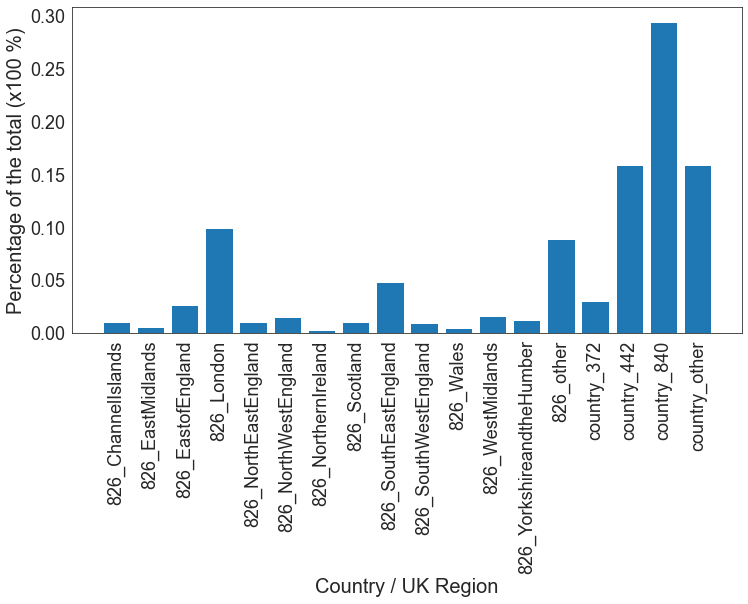

In [47]:
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(x=df_gb_countries['country_for_dummies'], height=df_gb_countries['pct'])
ax.tick_params(axis='x', labelsize=18, rotation=90)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('Percentage of the total (x100 %)', fontsize=20)
ax.set_xlabel('Country / UK Region', fontsize=20)
# ax.set_title('Delay before reporting a transation as fraud (hours)')
# plt.legend(fontsize=14, frameon=False)
plt.savefig('fraudulent transactions per country.png', dpi=600, bbox_inches='tight')
plt.show()

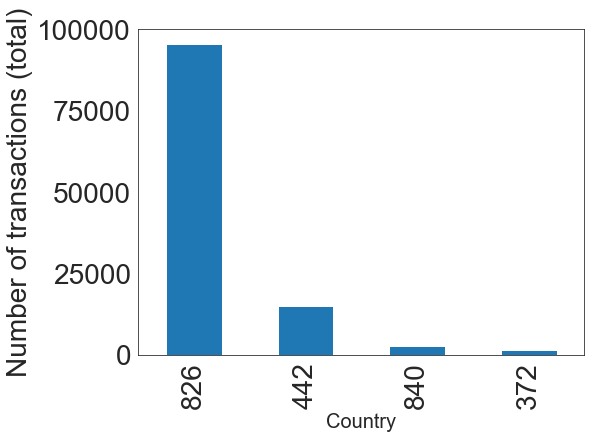

In [48]:
fig, ax = plt.subplots(figsize=(8,6))


df['merchant_country'].value_counts().head(4).plot(kind='bar', ax=ax)



ax.tick_params(axis='x', labelsize=28, rotation=90)
ax.tick_params(axis='y', labelsize=28)
ax.set_ylabel('Number of transactions (total)', fontsize=28)
ax.set_xlabel('Country', fontsize=20)
# ax.set_title('Delay before reporting a transation as fraud (hours)')
# plt.legend(fontsize=14, frameon=False)
plt.savefig('number of transactions per country.png', dpi=600, bbox_inches='tight')
plt.show()

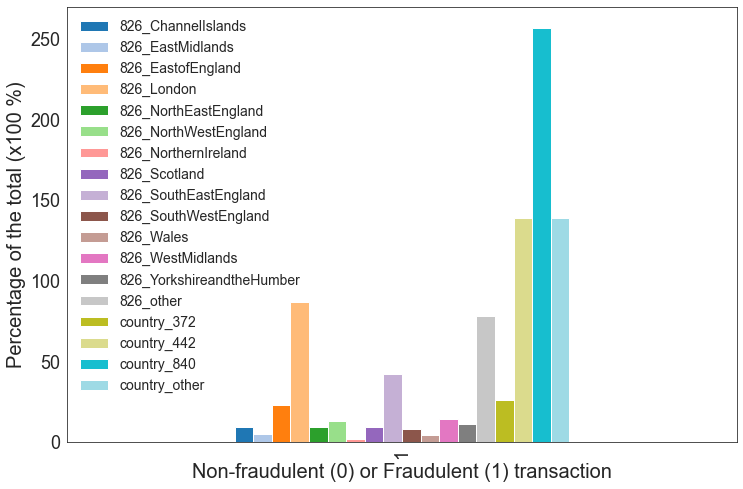

In [49]:


fig, ax = plt.subplots(figsize=(12,8))
df[df['fraud'] == 1].groupby(['fraud', 'country_for_dummies']).count()['event_id'].unstack().plot(kind='bar',
                                                                                                 colormap='tab20',
                                                                                                 ax=ax)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('Percentage of the total (x100 %)', fontsize=20)
ax.set_xlabel('Non-fraudulent (0) or Fraudulent (1) transaction', fontsize=20)
# ax.set_title('Delay before reporting a transation as fraud (hours)')
plt.legend(fontsize=14, frameon=False)
# plt.savefig('fraudulent vs non fraud pct POS mode.png', dpi=600, bbox_inches='tight')
plt.show()

Drop the created columns - no more need of them

In [50]:
df.drop(['merchant_zip', 'match', 'uk_region', 'transaction_time_year', 'transaction_time_month'], axis=1, inplace=True)

In [51]:
df.drop('post_code_start', axis=1, inplace=True)

Check missing values

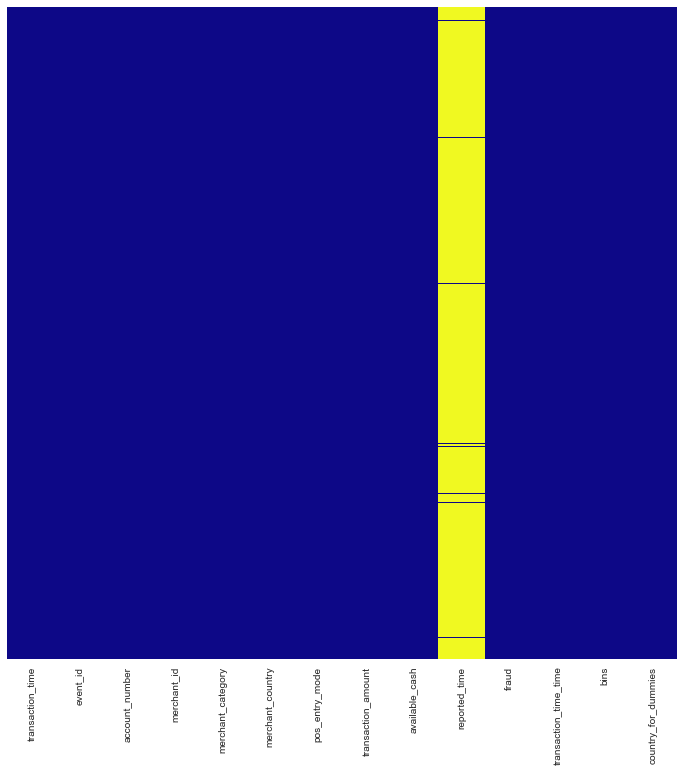

In [52]:
plt.subplots(figsize=(12, 12))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False, cmap='plasma')
plt.show()

Check empty values

In [53]:
df.isnull().sum()

transaction_time              0
event_id                      0
account_number                0
merchant_id                   0
merchant_category             0
merchant_country              0
pos_entry_mode                0
transaction_amount            0
available_cash                0
reported_time            117746
fraud                         0
transaction_time_time         0
bins                          0
country_for_dummies           0
dtype: int64

In [54]:
print_unique_values(df)

df length: 118621
Column name               | Unique
----------------------------------------
transaction_time          | 118105 
event_id                  | 118621 
account_number            | 766 
merchant_id               | 33327 
merchant_category         | 361 
merchant_country          | 82 
pos_entry_mode            | 10 
transaction_amount        | 19295 
available_cash            | 19 
reported_time             | 146 
fraud                     | 2 
transaction_time_time     | 64196 
bins                      | 4 
country_for_dummies       | 18 


No outliers or anything particular about the `merchant_category` distribution. `merchant_category` will be used for dummies, but given time, it can be tested what is the influence of the presence of the column as dummies in its raw form, or in some sort of engineered grouping

In [55]:
df['merchant_category'].value_counts().head(20)

023u221      23937
ec60070e      7510
dddb966rt     6341
fff07bzph     4125
adzz727i      3794
88bbb09k      2931
rf1e60c       2607
bb8ebe5w      2595
d7fbbbb       2282
09dac984      2219
4p89335c      2146
ga4eg1g       2092
b14313by      2028
eceddl1       1677
66r77072      1658
3bbf6s5uu     1589
h70944b       1436
f41f60nc      1414
m0m17m2s      1408
endfdf2hg     1404
Name: merchant_category, dtype: int64

# Train and Test data engineering

In [56]:
df.head()

,transaction_time,event_id,account_number,merchant_id,merchant_category,merchant_country,pos_entry_mode,transaction_amount,available_cash,reported_time,fraud,transaction_time_time,bins,country_for_dummies
0,2017-01-01 00:00:00+00:00,3uudfau,689e9eex9,a7214a1,09dac984,826,1,10.29,7249,NaT,0,00:00:00,20-02,826_London
1,2017-01-01 00:49:03+00:00,4534h14,35a333qg,3hh91886e,4p89335c,826,81,21.02,4689,NaT,0,00:49:03,20-02,826_EastMidlands
2,2017-01-01 00:43:17+00:00,s0b2ccs,8h8eefff,222c6f94r,adzz727i,442,81,5.48,10408,NaT,0,00:43:17,20-02,country_442
3,2017-01-01 00:15:07+00:00,fap81bbcg,7710hha8p,5a51a11,4p89335c,826,81,19.43,7249,NaT,0,00:15:07,20-02,826_EastofEngland
4,2017-01-01 00:37:09+00:00,c22dd72,9ff58c3qu,5e9c1cd,023u221,826,81,42.54,10807,NaT,0,00:37:09,20-02,826_NorthWestEngland


Drop columns that have no immediate value to the model, or the number of unique values is too large to create 1-hot dummies

In [57]:
drop_cols = ['transaction_time', 'event_id', 'account_number', 'merchant_id',
             'merchant_country', 'reported_time', 'transaction_time_time']

In [58]:
data = df.drop(columns=drop_cols)

In [59]:
data.head()

,merchant_category,pos_entry_mode,transaction_amount,available_cash,fraud,bins,country_for_dummies
0,09dac984,1,10.29,7249,0,20-02,826_London
1,4p89335c,81,21.02,4689,0,20-02,826_EastMidlands
2,adzz727i,81,5.48,10408,0,20-02,country_442
3,4p89335c,81,19.43,7249,0,20-02,826_EastofEngland
4,023u221,81,42.54,10807,0,20-02,826_NorthWestEngland


Create the dummies

In [60]:
dum_cols = ['pos_entry_mode', 'merchant_category', 'bins', 'country_for_dummies']

In [61]:
data_dum = pd.get_dummies(data, columns=dum_cols, drop_first=True)

In [62]:
data_dum.shape

(118621, 392)

In [63]:
data_dum.head()

,transaction_amount,available_cash,fraud,pos_entry_mode_1,pos_entry_mode_2,pos_entry_mode_5,pos_entry_mode_7,pos_entry_mode_79,pos_entry_mode_80,pos_entry_mode_81,...,country_for_dummies_826_SouthEastEngland,country_for_dummies_826_SouthWestEngland,country_for_dummies_826_Wales,country_for_dummies_826_WestMidlands,country_for_dummies_826_YorkshireandtheHumber,country_for_dummies_826_other,country_for_dummies_country_372,country_for_dummies_country_442,country_for_dummies_country_840,country_for_dummies_country_other
0,10.29,7249,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21.02,4689,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,5.48,10408,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,19.43,7249,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,42.54,10807,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


No missing values - as expected

In [64]:
data_dum.isnull().sum().sum()

0

# Modelling

Regarding the modelling and the ML, there are two approaches that can be used to treat a severely imbalanced dataset such as the one in this exercise.

- **Balancing the two classes**: Random sampling from the majority class an equal number of elements as the minority class, so a 50-50 split is created and a model is trained on the balanced dataset
- **Oversampling of the minority class**: Use some sort of statistical oversampling method of the minority class during the training of the model to achieve a balanced dataset

Depending on the problem at hand, even an imbalanced dataset but with enough examples of the minority class will be solved easily. However, in this case, 875 cases of the minority class might not be enough to create a solid model

## Balanced Model

First approach, and the more difficult given the small number of the minority class examples, is the balanced model.

Using the `.sample` method on a pandas dataframe, 875 (`len(df[df'fraud'] == 1])`) are randomly selected to create a balanced dataset of the `data_dum` dataframe that was previously created

In [65]:
data_dum_balanced = pd.concat([data_dum[data_dum['fraud'] == 0].sample(len(df[df['fraud'] == 1])),
                               data_dum[data_dum['fraud'] == 1]])
X_balanced = data_dum_balanced.drop('fraud', axis=1)
y_balanced = data_dum_balanced['fraud']

50-50 split

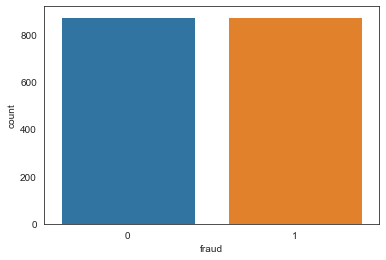

In [66]:
sns.countplot(y_balanced)

Split the balanced data into train and test

In [67]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


Use a `MinMaxScaler` to scale the data

In [68]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
X_train_bal = min_max_scaler.fit_transform(X_train_bal)
X_test_bal = min_max_scaler.transform(X_test_bal)

In [69]:
X_balanced.shape, y_balanced.shape

((1750, 391), (1750,))

### Random Forest

First approach using a Random Forest

In [70]:
rfc_bal = RandomForestClassifier(n_estimators=250, n_jobs=-1)
rfc_bal.fit(X_train_bal, y_train_bal)
pred_rfc_bal = rfc_bal.predict(X_test_bal)


Reasonable accuracy, precision and recall given the small number of samples

In [71]:
print(metrics.classification_report(y_test_bal, pred_rfc_bal))


              precision    recall  f1-score   support

           0       0.95      0.82      0.88       170
           1       0.85      0.96      0.90       180

    accuracy                           0.89       350
   macro avg       0.90      0.89      0.89       350
weighted avg       0.90      0.89      0.89       350



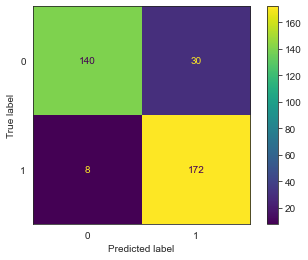

In [72]:
metrics.plot_confusion_matrix(rfc_bal, X=X_test_bal, y_true=y_test_bal)
plt.grid(False)
plt.show()

Scan through different number of estimators as a quick hyperparameter tuning

In [73]:
error_rate = list()
for i in notebook.tqdm(range(1, 500, 10)):
    rfc = RandomForestClassifier(n_estimators=i, n_jobs=-1)
    rfc.fit(X_train_bal, y_train_bal)
    pred_i = rfc.predict(X_test_bal)
    error_rate.append(np.mean(pred_i != y_test_bal))


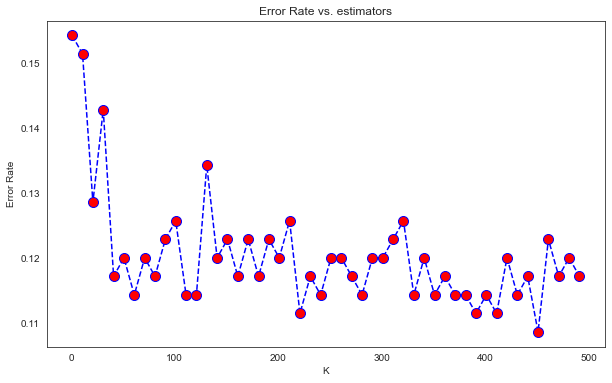

In [74]:
plt.figure(figsize=(10,6))
plt.plot(range(1,500, 10),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. estimators')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

### SVM

Second approach using Support Vector Machines and a quick grid seach on the `C` and `gamma` parameters

In [75]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}

In [76]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=10)
grid.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=0.1, gamma=1, score=0.832, total=   0.4s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.832, total=   0.4s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.832, total=   0.4s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.786, total=   0.4s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.857, total=   0.4s
[CV] C=0.1, gamma=0.1 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=0.1, score=0.793, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.3s remaining:    0.0s


[CV] .................... C=0.1, gamma=0.1, score=0.786, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.6s remaining:    0.0s


[CV] .................... C=0.1, gamma=0.1, score=0.782, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.9s remaining:    0.0s


[CV] .................... C=0.1, gamma=0.1, score=0.779, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.2s remaining:    0.0s


[CV] .................... C=0.1, gamma=0.1, score=0.814, total=   0.3s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................... C=0.1, gamma=0.01, score=0.775, total=   0.4s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................... C=0.1, gamma=0.01, score=0.793, total=   0.4s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................... C=0.1, gamma=0.01, score=0.786, total=   0.4s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................... C=0.1, gamma=0.01, score=0.782, total=   0.4s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................... C=0.1, gamma=0.01, score=0.818, total=   0.4s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .................. C=0.1, gamma=0.001, score=0.504, total=   0.4s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[CV] .................... C=100, gamma=0.1, score=0.857, total=   0.2s
[CV] C=100, gamma=0.1 ................................................
[CV] .................... C=100, gamma=0.1, score=0.821, total=   0.2s
[CV] C=100, gamma=0.1 ................................................
[CV] .................... C=100, gamma=0.1, score=0.846, total=   0.2s
[CV] C=100, gamma=0.01 ...............................................
[CV] ................... C=100, gamma=0.01, score=0.850, total=   0.2s
[CV] C=100, gamma=0.01 ...............................................
[CV] ................... C=100, gamma=0.01, score=0.861, total=   0.2s
[CV] C=100, gamma=0.01 ...............................................
[CV] ................... C=100, gamma=0.01, score=0.854, total=   0.2s
[CV] C=100, gamma=0.01 ...............................................
[CV] ................... C=100, gamma=0.01, score=0.832, total=   0.2s
[CV] C=100, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   24.4s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=10)

In [77]:
grid_predictions = grid.predict(X_test_bal)
print(metrics.confusion_matrix(y_test_bal, grid_predictions))

[[137  33]
 [ 21 159]]


In [78]:
print(metrics.classification_report(y_test_bal, grid_predictions))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       170
           1       0.83      0.88      0.85       180

    accuracy                           0.85       350
   macro avg       0.85      0.84      0.85       350
weighted avg       0.85      0.85      0.85       350



Reasonable performance with SVMs too, albeit slightly underperformed compared to the `rfc` above

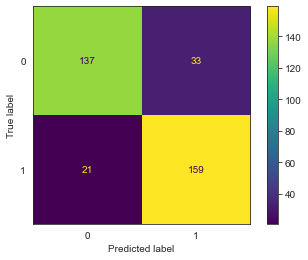

In [79]:
metrics.plot_confusion_matrix(grid, X=X_test_bal, y_true=y_test_bal)
plt.grid(False)
plt.show()

### Logistic Regression

Third approach with a logistic regression

In [80]:
param_grid = {'C': np.logspace(-4, 4, 4)}
grid = GridSearchCV(LogisticRegression(n_jobs=-1),
                    param_grid, refit=True, verbose=10)
grid.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=0.0001, score=0.650, total=   0.8s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ............................ C=0.0001, score=0.704, total=   0.4s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ............................ C=0.0001, score=0.671, total=   0.4s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] ............................ C=0.0001, score=0.664, total=   0.4s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s


[CV] ............................ C=0.0001, score=0.650, total=   0.4s
[CV] C=0.046415888336127774 ..........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s


[CV] .............. C=0.046415888336127774, score=0.796, total=   0.4s
[CV] C=0.046415888336127774 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.9s remaining:    0.0s


[CV] .............. C=0.046415888336127774, score=0.814, total=   0.4s
[CV] C=0.046415888336127774 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s remaining:    0.0s


[CV] .............. C=0.046415888336127774, score=0.793, total=   0.4s
[CV] C=0.046415888336127774 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.7s remaining:    0.0s


[CV] .............. C=0.046415888336127774, score=0.804, total=   0.4s
[CV] C=0.046415888336127774 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.2s remaining:    0.0s


[CV] .............. C=0.046415888336127774, score=0.846, total=   0.4s
[CV] C=21.54434690031882 .............................................
[CV] ................. C=21.54434690031882, score=0.846, total=   0.6s
[CV] C=21.54434690031882 .............................................
[CV] ................. C=21.54434690031882, score=0.864, total=   0.6s
[CV] C=21.54434690031882 .............................................
[CV] ................. C=21.54434690031882, score=0.843, total=   0.7s
[CV] C=21.54434690031882 .............................................
[CV] ................. C=21.54434690031882, score=0.825, total=   0.7s
[CV] C=21.54434690031882 .............................................
[CV] ................. C=21.54434690031882, score=0.861, total=   0.7s
[CV] C=10000.0 .......................................................
[CV] ........................... C=10000.0, score=0.829, total=   0.6s
[CV] C=10000.0 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.0s finished


GridSearchCV(estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04])},
             verbose=10)

In [81]:
grid_predictions = grid.predict(X_test_bal)
print(metrics.confusion_matrix(y_test_bal, grid_predictions))

[[133  37]
 [ 24 156]]


In [82]:
print(metrics.classification_report(y_test_bal, grid_predictions))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       170
           1       0.81      0.87      0.84       180

    accuracy                           0.83       350
   macro avg       0.83      0.82      0.82       350
weighted avg       0.83      0.83      0.83       350



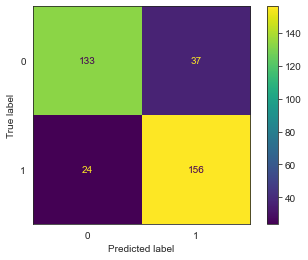

In [83]:
metrics.plot_confusion_matrix(grid, X=X_test_bal, y_true=y_test_bal)
plt.grid(False)
plt.show()

In [84]:
lg = LogisticRegression(max_iter=10000)
lg.fit(X_train_bal,y_train_bal)

LogisticRegression(max_iter=10000)

In [85]:
predictions = lg.predict(X_test_bal)


In [86]:
print(metrics.accuracy_score(y_true=y_test_bal, y_pred=predictions))
print(metrics.classification_report(y_test_bal,predictions))


0.8314285714285714
              precision    recall  f1-score   support

           0       0.87      0.76      0.82       170
           1       0.80      0.89      0.85       180

    accuracy                           0.83       350
   macro avg       0.84      0.83      0.83       350
weighted avg       0.84      0.83      0.83       350



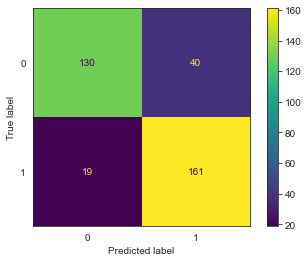

In [87]:
metrics.plot_confusion_matrix(lg, X=X_test_bal, y_true=y_test_bal)
plt.grid(False)
plt.show()

### Using neural networks

Further testing with neural networks and a fully connect deep network

#### NN Approach 1 - probability

In [88]:
n_inputs = X_train_bal.shape[1]

undersample_model = Sequential()

undersample_model.add(Dense(n_inputs, input_shape=(n_inputs, ), activation='tanh'))
undersample_model.add(Dropout(0.4))

undersample_model.add(Dense(n_inputs, activation='tanh'))
undersample_model.add(Dropout(0.4))

undersample_model.add(Dense(n_inputs, activation='tanh'))
undersample_model.add(Dropout(0.4))

undersample_model.add(Dense(n_inputs, activation='tanh'))
undersample_model.add(Dropout(0.4))

undersample_model.add(Dense(64, activation='tanh'))
undersample_model.add(Dropout(0.4))

undersample_model.add(Dense(1, activation='sigmoid'))


undersample_model.summary()

undersample_model.compile(optimizer=SGD(learning_rate=0.001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
undersample_model.fit(X_train_bal, y_train_bal,
                      validation_data=(X_test_bal, y_test_bal),
                      batch_size=128, epochs=400, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 391)               153272    
_________________________________________________________________
dropout (Dropout)            (None, 391)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 391)               153272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 391)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 391)               153272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 391)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 391)               1

Epoch 65/400
11/11 - 0s - loss: 0.5000 - accuracy: 0.7579 - val_loss: 0.4546 - val_accuracy: 0.7943
Epoch 66/400
11/11 - 0s - loss: 0.5275 - accuracy: 0.7550 - val_loss: 0.4530 - val_accuracy: 0.7943
Epoch 67/400
11/11 - 0s - loss: 0.5109 - accuracy: 0.7557 - val_loss: 0.4516 - val_accuracy: 0.7943
Epoch 68/400
11/11 - 0s - loss: 0.5127 - accuracy: 0.7671 - val_loss: 0.4501 - val_accuracy: 0.7943
Epoch 69/400
11/11 - 0s - loss: 0.5059 - accuracy: 0.7650 - val_loss: 0.4487 - val_accuracy: 0.7943
Epoch 70/400
11/11 - 0s - loss: 0.5034 - accuracy: 0.7664 - val_loss: 0.4473 - val_accuracy: 0.7943
Epoch 71/400
11/11 - 0s - loss: 0.4967 - accuracy: 0.7764 - val_loss: 0.4459 - val_accuracy: 0.7943
Epoch 72/400
11/11 - 0s - loss: 0.5116 - accuracy: 0.7571 - val_loss: 0.4445 - val_accuracy: 0.7943
Epoch 73/400
11/11 - 0s - loss: 0.4963 - accuracy: 0.7700 - val_loss: 0.4433 - val_accuracy: 0.7943
Epoch 74/400
11/11 - 0s - loss: 0.5066 - accuracy: 0.7543 - val_loss: 0.4421 - val_accuracy: 0.7914


Epoch 147/400
11/11 - 0s - loss: 0.4435 - accuracy: 0.7779 - val_loss: 0.3908 - val_accuracy: 0.7914
Epoch 148/400
11/11 - 0s - loss: 0.4390 - accuracy: 0.8079 - val_loss: 0.3905 - val_accuracy: 0.7914
Epoch 149/400
11/11 - 0s - loss: 0.4453 - accuracy: 0.7943 - val_loss: 0.3901 - val_accuracy: 0.7914
Epoch 150/400
11/11 - 0s - loss: 0.4428 - accuracy: 0.7864 - val_loss: 0.3897 - val_accuracy: 0.7914
Epoch 151/400
11/11 - 0s - loss: 0.4504 - accuracy: 0.7843 - val_loss: 0.3893 - val_accuracy: 0.7914
Epoch 152/400
11/11 - 0s - loss: 0.4576 - accuracy: 0.7921 - val_loss: 0.3889 - val_accuracy: 0.7914
Epoch 153/400
11/11 - 0s - loss: 0.4507 - accuracy: 0.7821 - val_loss: 0.3885 - val_accuracy: 0.7914
Epoch 154/400
11/11 - 0s - loss: 0.4415 - accuracy: 0.7871 - val_loss: 0.3881 - val_accuracy: 0.7914
Epoch 155/400
11/11 - 0s - loss: 0.4447 - accuracy: 0.7929 - val_loss: 0.3877 - val_accuracy: 0.7914
Epoch 156/400
11/11 - 0s - loss: 0.4419 - accuracy: 0.7800 - val_loss: 0.3873 - val_accurac

Epoch 229/400
11/11 - 0s - loss: 0.4239 - accuracy: 0.8029 - val_loss: 0.3678 - val_accuracy: 0.8314
Epoch 230/400
11/11 - 0s - loss: 0.4185 - accuracy: 0.7979 - val_loss: 0.3676 - val_accuracy: 0.8314
Epoch 231/400
11/11 - 0s - loss: 0.4272 - accuracy: 0.8036 - val_loss: 0.3673 - val_accuracy: 0.8314
Epoch 232/400
11/11 - 0s - loss: 0.4346 - accuracy: 0.8007 - val_loss: 0.3672 - val_accuracy: 0.8314
Epoch 233/400
11/11 - 0s - loss: 0.4227 - accuracy: 0.7979 - val_loss: 0.3670 - val_accuracy: 0.8314
Epoch 234/400
11/11 - 0s - loss: 0.4200 - accuracy: 0.7864 - val_loss: 0.3667 - val_accuracy: 0.8314
Epoch 235/400
11/11 - 0s - loss: 0.4229 - accuracy: 0.8064 - val_loss: 0.3665 - val_accuracy: 0.8314
Epoch 236/400
11/11 - 0s - loss: 0.4230 - accuracy: 0.7957 - val_loss: 0.3663 - val_accuracy: 0.8314
Epoch 237/400
11/11 - 0s - loss: 0.4258 - accuracy: 0.8043 - val_loss: 0.3662 - val_accuracy: 0.8314
Epoch 238/400
11/11 - 0s - loss: 0.4244 - accuracy: 0.7936 - val_loss: 0.3660 - val_accurac

Epoch 311/400
11/11 - 0s - loss: 0.4058 - accuracy: 0.8179 - val_loss: 0.3570 - val_accuracy: 0.8429
Epoch 312/400
11/11 - 0s - loss: 0.3921 - accuracy: 0.8100 - val_loss: 0.3570 - val_accuracy: 0.8429
Epoch 313/400
11/11 - 0s - loss: 0.4101 - accuracy: 0.8171 - val_loss: 0.3569 - val_accuracy: 0.8429
Epoch 314/400
11/11 - 0s - loss: 0.4137 - accuracy: 0.8150 - val_loss: 0.3569 - val_accuracy: 0.8429
Epoch 315/400
11/11 - 0s - loss: 0.4211 - accuracy: 0.7986 - val_loss: 0.3567 - val_accuracy: 0.8429
Epoch 316/400
11/11 - 0s - loss: 0.4117 - accuracy: 0.8186 - val_loss: 0.3567 - val_accuracy: 0.8429
Epoch 317/400
11/11 - 0s - loss: 0.4069 - accuracy: 0.8286 - val_loss: 0.3566 - val_accuracy: 0.8429
Epoch 318/400
11/11 - 0s - loss: 0.4108 - accuracy: 0.8150 - val_loss: 0.3565 - val_accuracy: 0.8429
Epoch 319/400
11/11 - 0s - loss: 0.4060 - accuracy: 0.8193 - val_loss: 0.3565 - val_accuracy: 0.8457
Epoch 320/400
11/11 - 0s - loss: 0.4040 - accuracy: 0.8114 - val_loss: 0.3564 - val_accurac

Epoch 393/400
11/11 - 0s - loss: 0.3896 - accuracy: 0.8179 - val_loss: 0.3529 - val_accuracy: 0.8429
Epoch 394/400
11/11 - 0s - loss: 0.3852 - accuracy: 0.8371 - val_loss: 0.3528 - val_accuracy: 0.8429
Epoch 395/400
11/11 - 0s - loss: 0.4007 - accuracy: 0.8329 - val_loss: 0.3529 - val_accuracy: 0.8429
Epoch 396/400
11/11 - 0s - loss: 0.3891 - accuracy: 0.8164 - val_loss: 0.3528 - val_accuracy: 0.8429
Epoch 397/400
11/11 - 0s - loss: 0.3995 - accuracy: 0.8157 - val_loss: 0.3528 - val_accuracy: 0.8429
Epoch 398/400
11/11 - 0s - loss: 0.3853 - accuracy: 0.8236 - val_loss: 0.3528 - val_accuracy: 0.8429
Epoch 399/400
11/11 - 0s - loss: 0.3892 - accuracy: 0.8221 - val_loss: 0.3527 - val_accuracy: 0.8429
Epoch 400/400
11/11 - 0s - loss: 0.3767 - accuracy: 0.8279 - val_loss: 0.3526 - val_accuracy: 0.8429


No overfitting observed, even after 400 epochs

In [89]:
losses = pd.DataFrame(undersample_model.history.history)


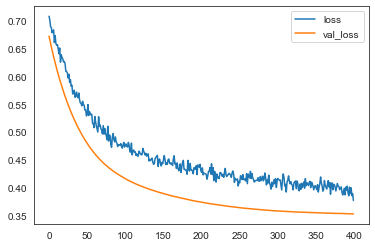

In [90]:
losses[['loss','val_loss']].plot()

`undersample_model.predict(X_test)` can be interpreted as a probability of having a class, therefore the threshold we set will adjust the confusion matrix, and consequently the recall/precision

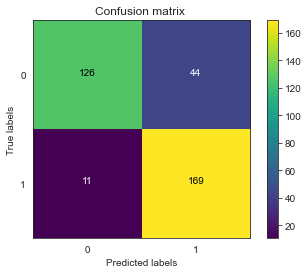

In [91]:
pred = (undersample_model.predict(X_test_bal) > 0.5).astype("int32")
cm = metrics.confusion_matrix(y_test_bal,pred)

plt.imshow(cm, cmap='viridis')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="black" if cm[i, j] > thresh else "white")

plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

Reasonable performance with the NN, with a smaller number of FP compared to FN

## Unbalanced data - oversampling

Second approach to the imbalanced dataset using an oversampling method from the `imblearn` library and the `SMOTE` approach

In [92]:
sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [93]:
X = data_dum.drop('fraud', axis=1)
y = data_dum['fraud']

In [94]:
X.shape, y.shape

((118621, 391), (118621,))

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

**The cell below will take about 2h40m to run with the specified parameters on a reasonably quick AMD Ryzen 7 8-core 3700X @ >4GHz**

Loop through the train and test of the cross validation, train the `rfc` classifier with different number of estimators and print the various scores available

In [96]:
# rfc_params = {"n_estimators": [100, 150, 200, 250, 300, 350]}
# rand_rfc = RandomizedSearchCV(RandomForestClassifier(),
#                                   rfc_params)

# accuracy_lst = []
# precision_lst = []
# recall_lst = []
# f1_lst = []
# auc_lst = []

# i = 0
# for train, test in notebook.tqdm(sss.split(X_train, y_train), total=5):
#     print(f'Iter {i}')
#     i += 1
#     # SMOTE happens during Cross Validation not before..
#     pipeline = make_pipeline(SMOTE(sampling_strategy='minority', n_jobs=-1),
#                              rand_rfc)
#     print('\t fitting')
#     model = pipeline.fit(X_train[train], y_train.values[train])
#     print('\t best est')
#     best_est = rand_rfc.best_estimator_
#     print('\t predicting')
#     prediction = best_est.predict(X_train[test])

#     accuracy_lst.append(pipeline.score(X_train[test], y_train.values[test]))
#     precision_lst.append(metrics.precision_score(y_train.values[test], prediction))
#     recall_lst.append(metrics.recall_score(y_train.values[test], prediction))
#     f1_lst.append(metrics.f1_score(y_train.values[test], prediction))
#     auc_lst.append(metrics.roc_auc_score(y_train.values[test], prediction))


# print('')
# print("accuracy: {}".format(np.mean(accuracy_lst)))
# print("precision: {}".format(np.mean(precision_lst)))
# print("recall: {}".format(np.mean(recall_lst)))
# print("f1: {}".format(np.mean(f1_lst)))


# labels = ['No Fraud', 'Fraud']
# smote_prediction = best_est.predict(X_test)
# print(metrics.classification_report(y_test, smote_prediction, target_names=labels))


# cm = metrics.confusion_matrix(y_test, smote_prediction)

# plt.imshow(cm, cmap='viridis')
# plt.xlabel("Predicted labels")
# plt.ylabel("True labels")
# plt.xticks([0, 1], [0, 1])
# plt.yticks([0, 1], [0, 1])

# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], 'd'),
#              horizontalalignment="center",
#              color="black" if cm[i, j] > thresh else "white")

# plt.title('Confusion matrix ')
# plt.colorbar()
# plt.show()

The model was not performing great when it comes to classifying the frauds with a high Type II error

Re train the SMOTE on a new dataset

In [97]:
sm = SMOTE(random_state=42)

In [98]:
Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

In [99]:
t0 = time.time()
rfc.fit(Xsm_train, ysm_train)
t1 = time.time()
print(f"Fitting oversample data took :{t1 - t0} sec")

Fitting oversample data took :66.80834245681763 sec


Predict with the previously train classifier

In [100]:
pred_rfc_sm = rfc.predict(X_test)

In [101]:
print(metrics.classification_report(y_test, pred_rfc_sm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35300
           1       0.48      0.45      0.47       287

    accuracy                           0.99     35587
   macro avg       0.74      0.72      0.73     35587
weighted avg       0.99      0.99      0.99     35587



In [102]:
y_test.value_counts()

0    35300
1      287
Name: fraud, dtype: int64

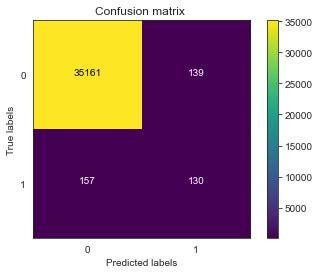

In [103]:
cm = metrics.confusion_matrix(y_test, pred_rfc_sm)

plt.imshow(cm, cmap='viridis')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="black" if cm[i, j] > thresh else "white")

plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

In [104]:
Xsm_train.shape

(164892, 391)

In [105]:
ysm_train.shape

(164892,)

In [106]:
ysm_train.value_counts()

1    82446
0    82446
Name: fraud, dtype: int64

### Neural network on the oversampled dataset

**Note the cell below took ~15 min to run on the same AMD processor as above but with the help of an NVIDIA RTX 2070 SUPER**

Use the same model architecture as the one in the undersampled data to be trained on the new oversampled data

In [107]:
n_inputs = X_train.shape[1]

oversample_model = Sequential()

oversample_model.add(Dense(n_inputs, input_shape=(n_inputs, ), activation='tanh'))
oversample_model.add(Dropout(0.4))

oversample_model.add(Dense(n_inputs, activation='tanh'))
oversample_model.add(Dropout(0.4))

oversample_model.add(Dense(n_inputs, activation='tanh'))
oversample_model.add(Dropout(0.4))

oversample_model.add(Dense(n_inputs, activation='tanh'))
oversample_model.add(Dropout(0.4))

oversample_model.add(Dense(64, activation='tanh'))
oversample_model.add(Dropout(0.4))

oversample_model.add(Dense(1, activation='sigmoid'))


oversample_model.summary()

oversample_model.compile(optimizer=SGD(learning_rate=0.001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
oversample_model.fit(Xsm_train, ysm_train,
                      validation_data=(X_test, y_test),
                      batch_size=128, epochs=1200, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 391)               153272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 391)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 391)               153272    
_________________________________________________________________
dropout_6 (Dropout)          (None, 391)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 391)               153272    
_________________________________________________________________
dropout_7 (Dropout)          (None, 391)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 391)              

Epoch 62/1200
1289/1289 - 2s - loss: 0.2901 - accuracy: 0.8818 - val_loss: 0.3486 - val_accuracy: 0.8412
Epoch 63/1200
1289/1289 - 2s - loss: 0.2892 - accuracy: 0.8824 - val_loss: 0.3430 - val_accuracy: 0.8433
Epoch 64/1200
1289/1289 - 2s - loss: 0.2891 - accuracy: 0.8822 - val_loss: 0.3455 - val_accuracy: 0.8418
Epoch 65/1200
1289/1289 - 2s - loss: 0.2891 - accuracy: 0.8819 - val_loss: 0.3437 - val_accuracy: 0.8426
Epoch 66/1200
1289/1289 - 2s - loss: 0.2885 - accuracy: 0.8827 - val_loss: 0.3430 - val_accuracy: 0.8428
Epoch 67/1200
1289/1289 - 2s - loss: 0.2882 - accuracy: 0.8829 - val_loss: 0.3425 - val_accuracy: 0.8429
Epoch 68/1200
1289/1289 - 2s - loss: 0.2877 - accuracy: 0.8837 - val_loss: 0.3400 - val_accuracy: 0.8443
Epoch 69/1200
1289/1289 - 2s - loss: 0.2880 - accuracy: 0.8825 - val_loss: 0.3370 - val_accuracy: 0.8458
Epoch 70/1200
1289/1289 - 2s - loss: 0.2879 - accuracy: 0.8831 - val_loss: 0.3436 - val_accuracy: 0.8420
Epoch 71/1200
1289/1289 - 2s - loss: 0.2867 - accuracy:

Epoch 140/1200
1289/1289 - 2s - loss: 0.2696 - accuracy: 0.8945 - val_loss: 0.3374 - val_accuracy: 0.8441
Epoch 141/1200
1289/1289 - 2s - loss: 0.2698 - accuracy: 0.8940 - val_loss: 0.3413 - val_accuracy: 0.8417
Epoch 142/1200
1289/1289 - 2s - loss: 0.2694 - accuracy: 0.8939 - val_loss: 0.3410 - val_accuracy: 0.8417
Epoch 143/1200
1289/1289 - 2s - loss: 0.2685 - accuracy: 0.8946 - val_loss: 0.3347 - val_accuracy: 0.8450
Epoch 144/1200
1289/1289 - 2s - loss: 0.2693 - accuracy: 0.8941 - val_loss: 0.3377 - val_accuracy: 0.8426
Epoch 145/1200
1289/1289 - 2s - loss: 0.2697 - accuracy: 0.8939 - val_loss: 0.3341 - val_accuracy: 0.8445
Epoch 146/1200
1289/1289 - 2s - loss: 0.2684 - accuracy: 0.8943 - val_loss: 0.3259 - val_accuracy: 0.8489
Epoch 147/1200
1289/1289 - 2s - loss: 0.2685 - accuracy: 0.8950 - val_loss: 0.3369 - val_accuracy: 0.8434
Epoch 148/1200
1289/1289 - 2s - loss: 0.2684 - accuracy: 0.8946 - val_loss: 0.3328 - val_accuracy: 0.8450
Epoch 149/1200
1289/1289 - 2s - loss: 0.2680 -

Epoch 218/1200
1289/1289 - 2s - loss: 0.2547 - accuracy: 0.8999 - val_loss: 0.3197 - val_accuracy: 0.8453
Epoch 219/1200
1289/1289 - 2s - loss: 0.2543 - accuracy: 0.8999 - val_loss: 0.3247 - val_accuracy: 0.8425
Epoch 220/1200
1289/1289 - 2s - loss: 0.2546 - accuracy: 0.9002 - val_loss: 0.3187 - val_accuracy: 0.8453
Epoch 221/1200
1289/1289 - 2s - loss: 0.2540 - accuracy: 0.8999 - val_loss: 0.3177 - val_accuracy: 0.8457
Epoch 222/1200
1289/1289 - 2s - loss: 0.2539 - accuracy: 0.8997 - val_loss: 0.3169 - val_accuracy: 0.8459
Epoch 223/1200
1289/1289 - 2s - loss: 0.2530 - accuracy: 0.9001 - val_loss: 0.3099 - val_accuracy: 0.8487
Epoch 224/1200
1289/1289 - 2s - loss: 0.2539 - accuracy: 0.8998 - val_loss: 0.3214 - val_accuracy: 0.8438
Epoch 225/1200
1289/1289 - 2s - loss: 0.2531 - accuracy: 0.9001 - val_loss: 0.3148 - val_accuracy: 0.8470
Epoch 226/1200
1289/1289 - 2s - loss: 0.2527 - accuracy: 0.9007 - val_loss: 0.3156 - val_accuracy: 0.8467
Epoch 227/1200
1289/1289 - 2s - loss: 0.2523 -

Epoch 296/1200
1289/1289 - 2s - loss: 0.2379 - accuracy: 0.9074 - val_loss: 0.2951 - val_accuracy: 0.8556
Epoch 297/1200
1289/1289 - 2s - loss: 0.2376 - accuracy: 0.9079 - val_loss: 0.2979 - val_accuracy: 0.8543
Epoch 298/1200
1289/1289 - 2s - loss: 0.2375 - accuracy: 0.9079 - val_loss: 0.2980 - val_accuracy: 0.8546
Epoch 299/1200
1289/1289 - 2s - loss: 0.2382 - accuracy: 0.9077 - val_loss: 0.3022 - val_accuracy: 0.8525
Epoch 300/1200
1289/1289 - 2s - loss: 0.2375 - accuracy: 0.9083 - val_loss: 0.3002 - val_accuracy: 0.8542
Epoch 301/1200
1289/1289 - 2s - loss: 0.2370 - accuracy: 0.9076 - val_loss: 0.2977 - val_accuracy: 0.8552
Epoch 302/1200
1289/1289 - 2s - loss: 0.2367 - accuracy: 0.9087 - val_loss: 0.3002 - val_accuracy: 0.8536
Epoch 303/1200
1289/1289 - 2s - loss: 0.2366 - accuracy: 0.9085 - val_loss: 0.3020 - val_accuracy: 0.8528
Epoch 304/1200
1289/1289 - 2s - loss: 0.2369 - accuracy: 0.9083 - val_loss: 0.2980 - val_accuracy: 0.8554
Epoch 305/1200
1289/1289 - 2s - loss: 0.2364 -

Epoch 374/1200
1289/1289 - 2s - loss: 0.2275 - accuracy: 0.9152 - val_loss: 0.2866 - val_accuracy: 0.8725
Epoch 375/1200
1289/1289 - 2s - loss: 0.2272 - accuracy: 0.9147 - val_loss: 0.2860 - val_accuracy: 0.8723
Epoch 376/1200
1289/1289 - 2s - loss: 0.2267 - accuracy: 0.9151 - val_loss: 0.2810 - val_accuracy: 0.8762
Epoch 377/1200
1289/1289 - 2s - loss: 0.2272 - accuracy: 0.9150 - val_loss: 0.2857 - val_accuracy: 0.8737
Epoch 378/1200
1289/1289 - 2s - loss: 0.2265 - accuracy: 0.9155 - val_loss: 0.2869 - val_accuracy: 0.8722
Epoch 379/1200
1289/1289 - 2s - loss: 0.2257 - accuracy: 0.9155 - val_loss: 0.2888 - val_accuracy: 0.8718
Epoch 380/1200
1289/1289 - 2s - loss: 0.2261 - accuracy: 0.9160 - val_loss: 0.2862 - val_accuracy: 0.8731
Epoch 381/1200
1289/1289 - 2s - loss: 0.2265 - accuracy: 0.9149 - val_loss: 0.2838 - val_accuracy: 0.8746
Epoch 382/1200
1289/1289 - 2s - loss: 0.2259 - accuracy: 0.9152 - val_loss: 0.2811 - val_accuracy: 0.8761
Epoch 383/1200
1289/1289 - 2s - loss: 0.2263 -

Epoch 452/1200
1289/1289 - 2s - loss: 0.2171 - accuracy: 0.9217 - val_loss: 0.2701 - val_accuracy: 0.8905
Epoch 453/1200
1289/1289 - 2s - loss: 0.2175 - accuracy: 0.9214 - val_loss: 0.2717 - val_accuracy: 0.8894
Epoch 454/1200
1289/1289 - 2s - loss: 0.2164 - accuracy: 0.9220 - val_loss: 0.2736 - val_accuracy: 0.8886
Epoch 455/1200
1289/1289 - 2s - loss: 0.2170 - accuracy: 0.9216 - val_loss: 0.2706 - val_accuracy: 0.8902
Epoch 456/1200
1289/1289 - 2s - loss: 0.2169 - accuracy: 0.9213 - val_loss: 0.2720 - val_accuracy: 0.8905
Epoch 457/1200
1289/1289 - 2s - loss: 0.2168 - accuracy: 0.9221 - val_loss: 0.2743 - val_accuracy: 0.8881
Epoch 458/1200
1289/1289 - 2s - loss: 0.2167 - accuracy: 0.9221 - val_loss: 0.2758 - val_accuracy: 0.8879
Epoch 459/1200
1289/1289 - 2s - loss: 0.2155 - accuracy: 0.9229 - val_loss: 0.2731 - val_accuracy: 0.8899
Epoch 460/1200
1289/1289 - 2s - loss: 0.2156 - accuracy: 0.9224 - val_loss: 0.2745 - val_accuracy: 0.8880
Epoch 461/1200
1289/1289 - 2s - loss: 0.2163 -

Epoch 530/1200
1289/1289 - 2s - loss: 0.2081 - accuracy: 0.9267 - val_loss: 0.2614 - val_accuracy: 0.9013
Epoch 531/1200
1289/1289 - 2s - loss: 0.2086 - accuracy: 0.9268 - val_loss: 0.2578 - val_accuracy: 0.9034
Epoch 532/1200
1289/1289 - 2s - loss: 0.2089 - accuracy: 0.9263 - val_loss: 0.2577 - val_accuracy: 0.9022
Epoch 533/1200
1289/1289 - 2s - loss: 0.2079 - accuracy: 0.9269 - val_loss: 0.2609 - val_accuracy: 0.9035
Epoch 534/1200
1289/1289 - 2s - loss: 0.2079 - accuracy: 0.9269 - val_loss: 0.2633 - val_accuracy: 0.9026
Epoch 535/1200
1289/1289 - 2s - loss: 0.2081 - accuracy: 0.9276 - val_loss: 0.2634 - val_accuracy: 0.9010
Epoch 536/1200
1289/1289 - 2s - loss: 0.2077 - accuracy: 0.9272 - val_loss: 0.2573 - val_accuracy: 0.9055
Epoch 537/1200
1289/1289 - 2s - loss: 0.2074 - accuracy: 0.9277 - val_loss: 0.2609 - val_accuracy: 0.9040
Epoch 538/1200
1289/1289 - 2s - loss: 0.2076 - accuracy: 0.9272 - val_loss: 0.2607 - val_accuracy: 0.9028
Epoch 539/1200
1289/1289 - 2s - loss: 0.2077 -

Epoch 608/1200
1289/1289 - 2s - loss: 0.2018 - accuracy: 0.9313 - val_loss: 0.2481 - val_accuracy: 0.9108
Epoch 609/1200
1289/1289 - 2s - loss: 0.2018 - accuracy: 0.9312 - val_loss: 0.2539 - val_accuracy: 0.9086
Epoch 610/1200
1289/1289 - 2s - loss: 0.2021 - accuracy: 0.9315 - val_loss: 0.2534 - val_accuracy: 0.9094
Epoch 611/1200
1289/1289 - 2s - loss: 0.2018 - accuracy: 0.9310 - val_loss: 0.2454 - val_accuracy: 0.9123
Epoch 612/1200
1289/1289 - 2s - loss: 0.2018 - accuracy: 0.9314 - val_loss: 0.2464 - val_accuracy: 0.9120
Epoch 613/1200
1289/1289 - 2s - loss: 0.2010 - accuracy: 0.9313 - val_loss: 0.2516 - val_accuracy: 0.9102
Epoch 614/1200
1289/1289 - 2s - loss: 0.2005 - accuracy: 0.9318 - val_loss: 0.2484 - val_accuracy: 0.9115
Epoch 615/1200
1289/1289 - 2s - loss: 0.2003 - accuracy: 0.9320 - val_loss: 0.2530 - val_accuracy: 0.9088
Epoch 616/1200
1289/1289 - 2s - loss: 0.2007 - accuracy: 0.9320 - val_loss: 0.2484 - val_accuracy: 0.9108
Epoch 617/1200
1289/1289 - 2s - loss: 0.2007 -

Epoch 686/1200
1289/1289 - 2s - loss: 0.1969 - accuracy: 0.9350 - val_loss: 0.2453 - val_accuracy: 0.9143
Epoch 687/1200
1289/1289 - 2s - loss: 0.1975 - accuracy: 0.9345 - val_loss: 0.2468 - val_accuracy: 0.9129
Epoch 688/1200
1289/1289 - 2s - loss: 0.1974 - accuracy: 0.9344 - val_loss: 0.2409 - val_accuracy: 0.9156
Epoch 689/1200
1289/1289 - 2s - loss: 0.1973 - accuracy: 0.9347 - val_loss: 0.2471 - val_accuracy: 0.9125
Epoch 690/1200
1289/1289 - 2s - loss: 0.1967 - accuracy: 0.9350 - val_loss: 0.2410 - val_accuracy: 0.9159
Epoch 691/1200
1289/1289 - 2s - loss: 0.1964 - accuracy: 0.9349 - val_loss: 0.2466 - val_accuracy: 0.9136
Epoch 692/1200
1289/1289 - 2s - loss: 0.1963 - accuracy: 0.9351 - val_loss: 0.2425 - val_accuracy: 0.9148
Epoch 693/1200
1289/1289 - 2s - loss: 0.1967 - accuracy: 0.9351 - val_loss: 0.2431 - val_accuracy: 0.9146
Epoch 694/1200
1289/1289 - 2s - loss: 0.1967 - accuracy: 0.9351 - val_loss: 0.2445 - val_accuracy: 0.9147
Epoch 695/1200
1289/1289 - 2s - loss: 0.1965 -

Epoch 764/1200
1289/1289 - 2s - loss: 0.1930 - accuracy: 0.9372 - val_loss: 0.2370 - val_accuracy: 0.9191
Epoch 765/1200
1289/1289 - 2s - loss: 0.1933 - accuracy: 0.9373 - val_loss: 0.2376 - val_accuracy: 0.9183
Epoch 766/1200
1289/1289 - 2s - loss: 0.1930 - accuracy: 0.9372 - val_loss: 0.2416 - val_accuracy: 0.9158
Epoch 767/1200
1289/1289 - 2s - loss: 0.1929 - accuracy: 0.9377 - val_loss: 0.2401 - val_accuracy: 0.9170
Epoch 768/1200
1289/1289 - 2s - loss: 0.1931 - accuracy: 0.9374 - val_loss: 0.2353 - val_accuracy: 0.9186
Epoch 769/1200
1289/1289 - 2s - loss: 0.1935 - accuracy: 0.9370 - val_loss: 0.2410 - val_accuracy: 0.9157
Epoch 770/1200
1289/1289 - 2s - loss: 0.1937 - accuracy: 0.9373 - val_loss: 0.2390 - val_accuracy: 0.9169
Epoch 771/1200
1289/1289 - 2s - loss: 0.1930 - accuracy: 0.9376 - val_loss: 0.2368 - val_accuracy: 0.9178
Epoch 772/1200
1289/1289 - 2s - loss: 0.1934 - accuracy: 0.9378 - val_loss: 0.2412 - val_accuracy: 0.9155
Epoch 773/1200
1289/1289 - 2s - loss: 0.1934 -

Epoch 842/1200
1289/1289 - 2s - loss: 0.1904 - accuracy: 0.9387 - val_loss: 0.2379 - val_accuracy: 0.9177
Epoch 843/1200
1289/1289 - 2s - loss: 0.1913 - accuracy: 0.9383 - val_loss: 0.2415 - val_accuracy: 0.9155
Epoch 844/1200
1289/1289 - 2s - loss: 0.1904 - accuracy: 0.9391 - val_loss: 0.2403 - val_accuracy: 0.9166
Epoch 845/1200
1289/1289 - 2s - loss: 0.1906 - accuracy: 0.9387 - val_loss: 0.2403 - val_accuracy: 0.9166
Epoch 846/1200
1289/1289 - 2s - loss: 0.1907 - accuracy: 0.9387 - val_loss: 0.2345 - val_accuracy: 0.9192
Epoch 847/1200
1289/1289 - 2s - loss: 0.1907 - accuracy: 0.9393 - val_loss: 0.2411 - val_accuracy: 0.9157
Epoch 848/1200
1289/1289 - 2s - loss: 0.1910 - accuracy: 0.9388 - val_loss: 0.2401 - val_accuracy: 0.9174
Epoch 849/1200
1289/1289 - 2s - loss: 0.1902 - accuracy: 0.9390 - val_loss: 0.2425 - val_accuracy: 0.9160
Epoch 850/1200
1289/1289 - 2s - loss: 0.1903 - accuracy: 0.9390 - val_loss: 0.2386 - val_accuracy: 0.9184
Epoch 851/1200
1289/1289 - 2s - loss: 0.1910 -

Epoch 920/1200
1289/1289 - 2s - loss: 0.1882 - accuracy: 0.9400 - val_loss: 0.2444 - val_accuracy: 0.9156
Epoch 921/1200
1289/1289 - 2s - loss: 0.1887 - accuracy: 0.9399 - val_loss: 0.2451 - val_accuracy: 0.9156
Epoch 922/1200
1289/1289 - 2s - loss: 0.1887 - accuracy: 0.9397 - val_loss: 0.2315 - val_accuracy: 0.9204
Epoch 923/1200
1289/1289 - 2s - loss: 0.1880 - accuracy: 0.9403 - val_loss: 0.2408 - val_accuracy: 0.9165
Epoch 924/1200
1289/1289 - 2s - loss: 0.1888 - accuracy: 0.9399 - val_loss: 0.2354 - val_accuracy: 0.9191
Epoch 925/1200
1289/1289 - 2s - loss: 0.1884 - accuracy: 0.9400 - val_loss: 0.2374 - val_accuracy: 0.9181
Epoch 926/1200
1289/1289 - 2s - loss: 0.1885 - accuracy: 0.9399 - val_loss: 0.2346 - val_accuracy: 0.9194
Epoch 927/1200
1289/1289 - 2s - loss: 0.1882 - accuracy: 0.9402 - val_loss: 0.2417 - val_accuracy: 0.9163
Epoch 928/1200
1289/1289 - 2s - loss: 0.1889 - accuracy: 0.9398 - val_loss: 0.2352 - val_accuracy: 0.9189
Epoch 929/1200
1289/1289 - 2s - loss: 0.1880 -

Epoch 998/1200
1289/1289 - 3s - loss: 0.1867 - accuracy: 0.9411 - val_loss: 0.2391 - val_accuracy: 0.9182
Epoch 999/1200
1289/1289 - 3s - loss: 0.1866 - accuracy: 0.9407 - val_loss: 0.2329 - val_accuracy: 0.9209
Epoch 1000/1200
1289/1289 - 2s - loss: 0.1860 - accuracy: 0.9410 - val_loss: 0.2300 - val_accuracy: 0.9221
Epoch 1001/1200
1289/1289 - 2s - loss: 0.1869 - accuracy: 0.9410 - val_loss: 0.2374 - val_accuracy: 0.9192
Epoch 1002/1200
1289/1289 - 2s - loss: 0.1856 - accuracy: 0.9411 - val_loss: 0.2358 - val_accuracy: 0.9190
Epoch 1003/1200
1289/1289 - 2s - loss: 0.1866 - accuracy: 0.9411 - val_loss: 0.2423 - val_accuracy: 0.9174
Epoch 1004/1200
1289/1289 - 2s - loss: 0.1859 - accuracy: 0.9414 - val_loss: 0.2314 - val_accuracy: 0.9214
Epoch 1005/1200
1289/1289 - 2s - loss: 0.1867 - accuracy: 0.9411 - val_loss: 0.2274 - val_accuracy: 0.9231
Epoch 1006/1200
1289/1289 - 2s - loss: 0.1862 - accuracy: 0.9413 - val_loss: 0.2358 - val_accuracy: 0.9195
Epoch 1007/1200
1289/1289 - 3s - loss: 

Epoch 1075/1200
1289/1289 - 2s - loss: 0.1843 - accuracy: 0.9418 - val_loss: 0.2321 - val_accuracy: 0.9209
Epoch 1076/1200
1289/1289 - 2s - loss: 0.1840 - accuracy: 0.9420 - val_loss: 0.2283 - val_accuracy: 0.9225
Epoch 1077/1200
1289/1289 - 2s - loss: 0.1842 - accuracy: 0.9420 - val_loss: 0.2318 - val_accuracy: 0.9213
Epoch 1078/1200
1289/1289 - 2s - loss: 0.1839 - accuracy: 0.9423 - val_loss: 0.2345 - val_accuracy: 0.9210
Epoch 1079/1200
1289/1289 - 2s - loss: 0.1843 - accuracy: 0.9418 - val_loss: 0.2428 - val_accuracy: 0.9169
Epoch 1080/1200
1289/1289 - 2s - loss: 0.1838 - accuracy: 0.9420 - val_loss: 0.2282 - val_accuracy: 0.9230
Epoch 1081/1200
1289/1289 - 2s - loss: 0.1847 - accuracy: 0.9420 - val_loss: 0.2253 - val_accuracy: 0.9244
Epoch 1082/1200
1289/1289 - 2s - loss: 0.1844 - accuracy: 0.9423 - val_loss: 0.2309 - val_accuracy: 0.9218
Epoch 1083/1200
1289/1289 - 2s - loss: 0.1832 - accuracy: 0.9425 - val_loss: 0.2339 - val_accuracy: 0.9208
Epoch 1084/1200
1289/1289 - 2s - loss

Epoch 1152/1200
1289/1289 - 2s - loss: 0.1823 - accuracy: 0.9429 - val_loss: 0.2343 - val_accuracy: 0.9207
Epoch 1153/1200
1289/1289 - 2s - loss: 0.1824 - accuracy: 0.9433 - val_loss: 0.2332 - val_accuracy: 0.9212
Epoch 1154/1200
1289/1289 - 2s - loss: 0.1825 - accuracy: 0.9427 - val_loss: 0.2331 - val_accuracy: 0.9216
Epoch 1155/1200
1289/1289 - 2s - loss: 0.1822 - accuracy: 0.9430 - val_loss: 0.2324 - val_accuracy: 0.9220
Epoch 1156/1200
1289/1289 - 2s - loss: 0.1827 - accuracy: 0.9430 - val_loss: 0.2335 - val_accuracy: 0.9219
Epoch 1157/1200
1289/1289 - 2s - loss: 0.1821 - accuracy: 0.9432 - val_loss: 0.2301 - val_accuracy: 0.9223
Epoch 1158/1200
1289/1289 - 2s - loss: 0.1827 - accuracy: 0.9431 - val_loss: 0.2232 - val_accuracy: 0.9246
Epoch 1159/1200
1289/1289 - 2s - loss: 0.1820 - accuracy: 0.9430 - val_loss: 0.2353 - val_accuracy: 0.9205
Epoch 1160/1200
1289/1289 - 2s - loss: 0.1817 - accuracy: 0.9434 - val_loss: 0.2292 - val_accuracy: 0.9229
Epoch 1161/1200
1289/1289 - 2s - loss

No overfitting observed and the model could possibly see an improvement with more time to train

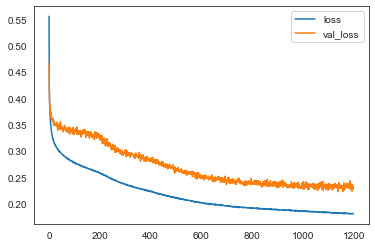

In [108]:
losses = pd.DataFrame(oversample_model.history.history)
losses[['loss','val_loss']].plot()

In [109]:
oversample_predictions = oversample_model.predict(X_test)

In [110]:
oversample_fraud_predictions = (oversample_model.predict(X_test) > 0.5).astype("int32")

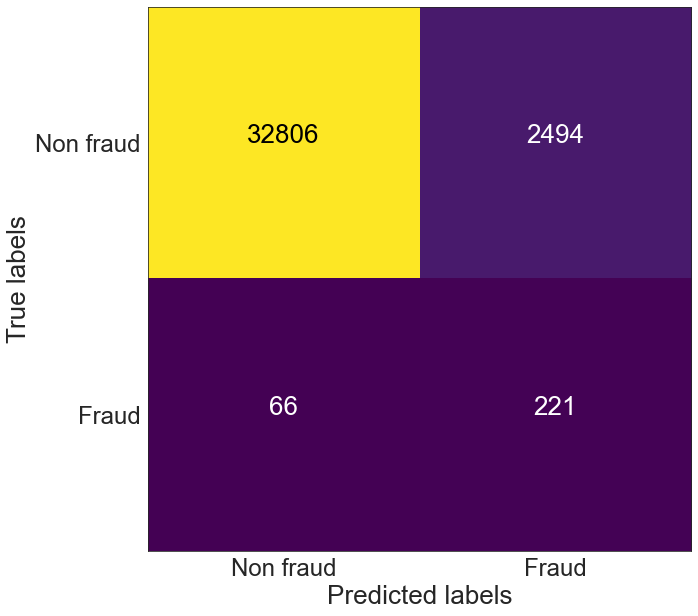

In [111]:
th = 0.7
oversample_fraud_predictions = (oversample_model.predict(X_test) > th).astype("int32")
cm = metrics.confusion_matrix(y_true=y_test,
                              y_pred=oversample_fraud_predictions)

plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='viridis')
plt.xlabel("Predicted labels", fontsize=26)
plt.ylabel("True labels", fontsize=26)
plt.xticks([0, 1], [0, 1])
plt.yticks([0, 1], [0, 1])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.xticks([0, 1], ['Non fraud', 'Fraud'])
plt.yticks([0, 1], ['Non fraud', 'Fraud'])


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), fontsize=26,
             horizontalalignment="center",
             color="black" if cm[i, j] > thresh else "white")

# plt.title('Confusion matrix ')
# plt.colorbar()
plt.savefig(f'nn_confusion_matrix_{th}.png', bbox_inches='tight', dpi=600)
plt.show()

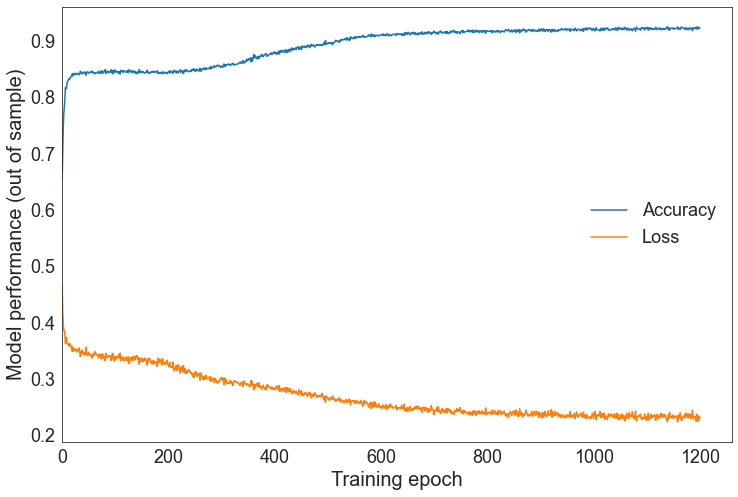

In [112]:


fig, ax = plt.subplots(figsize=(12,8))
ax.plot(losses.index, losses['val_accuracy'], label='Accuracy')
ax.plot(losses.index, losses['val_loss'], label='Loss')
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlim(0,)
ax.set_ylabel('Model performance (out of sample)', fontsize=20)
ax.set_xlabel('Training epoch', fontsize=20)
# ax.set_title('Delay before reporting a transation as fraud (hours)')
plt.legend(fontsize=18, frameon=False)
plt.savefig('modeltraining.png', dpi=600, bbox_inches='tight')
plt.show()

In [113]:
print(metrics.classification_report(y_test,oversample_fraud_predictions))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     35300
           1       0.08      0.77      0.15       287

    accuracy                           0.93     35587
   macro avg       0.54      0.85      0.55     35587
weighted avg       0.99      0.93      0.96     35587



So far, this model has the smallest Type I and Type II errors from the approaches examined

In [114]:
print(metrics.precision_score(y_true=y_test, y_pred=oversample_fraud_predictions))
print(metrics.accuracy_score(y_true=y_test, y_pred=oversample_fraud_predictions))
print(metrics.recall_score(y_true=y_test, y_pred=oversample_fraud_predictions))
print(metrics.f1_score(y_true=y_test, y_pred=oversample_fraud_predictions))

0.08139963167587477
0.9280636187371794
0.7700348432055749
0.14723517654896734


In [115]:
oversample_model.predict(X_test)

array([[4.2029927e-04],
       [5.2336760e-02],
       [9.5523357e-01],
       ...,
       [4.1896201e-04],
       [4.2314915e-04],
       [4.1769864e-04]], dtype=float32)

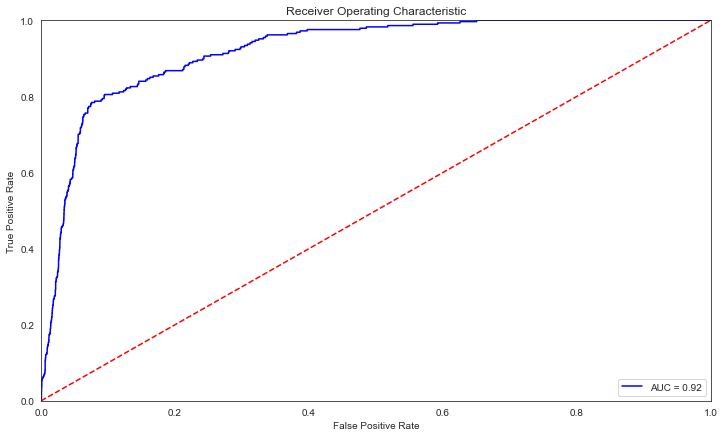

In [116]:
probs = oversample_model.predict(X_test)
preds = probs[:,0]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(12, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()